HSE, Applied Time Series Forecasitng , Spring 2022 

<font color="blue"> Lesson #8: Time Series Forecasting with ML </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - demand forecasting, lagged features, time series CV

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

# Demand Time Series

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityWAPE, qualityRMSE
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

In [8]:
# ! pip install --upgrade Cython
# ! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm

In [9]:
# загружаем данные
ts_retail = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep=';')
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], dayfirst = True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN
2015-01-02,1,1,NaN,41.0,163.78,NaN
2015-01-03,1,1,NaN,35.0,163.78,NaN
2015-01-04,1,1,NaN,72.0,163.78,NaN
2015-01-05,1,1,NaN,25.0,163.78,NaN


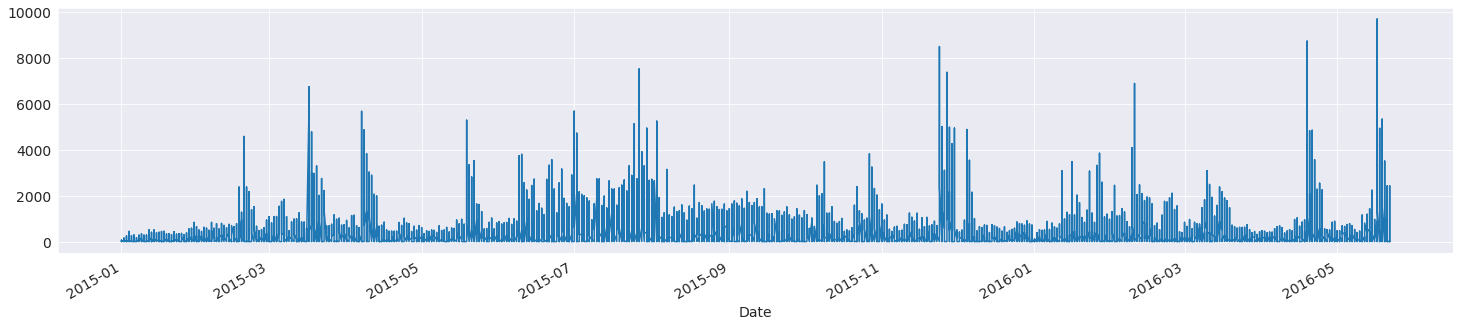

In [10]:
ts_retail['Demand'].plot()

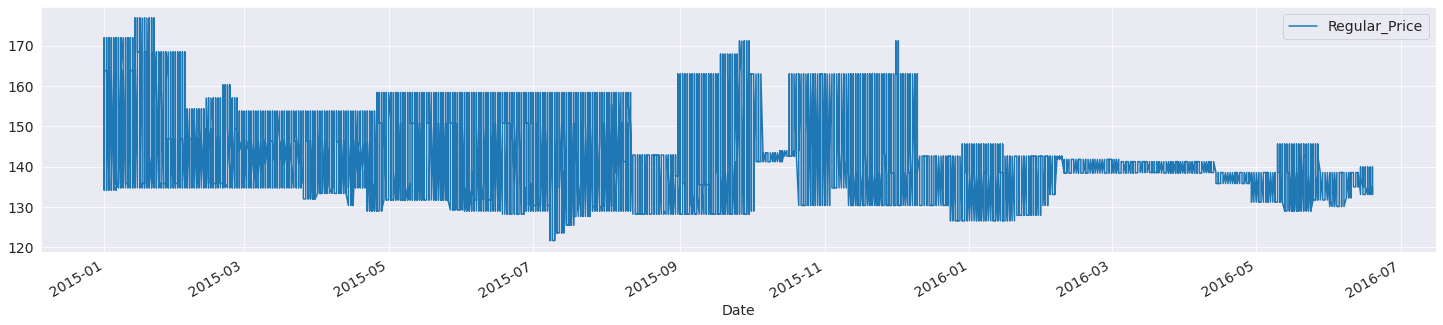

<Figure size 1800x360 with 0 Axes>

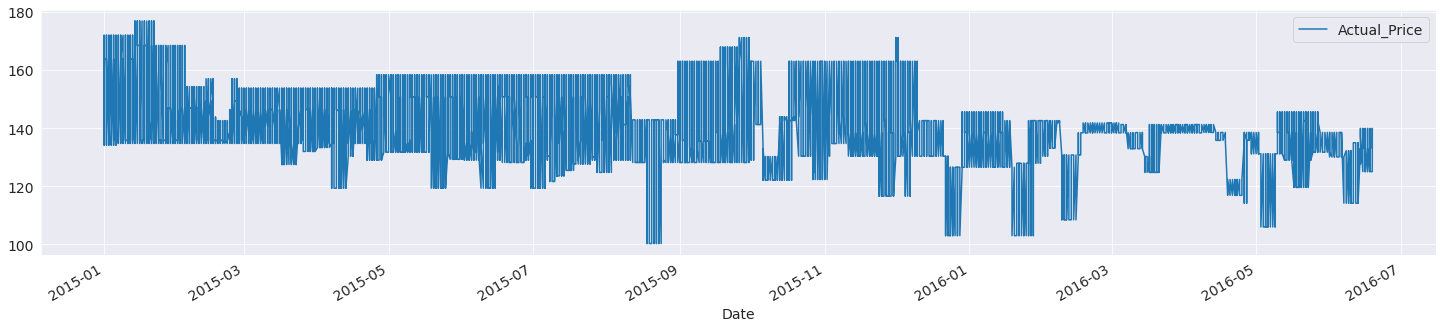

In [11]:
# Fill missings  (note: step is domain specific)
ts_retail['Promo'] = ts_retail['Promo'].fillna(0)
ts_retail.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
ts_retail['Regular_Price'] = ts_retail['Regular_Price'].ffill().bfill()
ts_retail.reset_index().set_index(['Date'], inplace=True)
ts_retail[['Regular_Price']].plot()

# Add actual price (promo price when promo occurred or regular price otherwise)
plt.figure()
ts_retail['Actual_Price'] = ts_retail.Promo_Price.combine_first(ts_retail.Regular_Price) 
ts_retail[['Actual_Price']].plot()

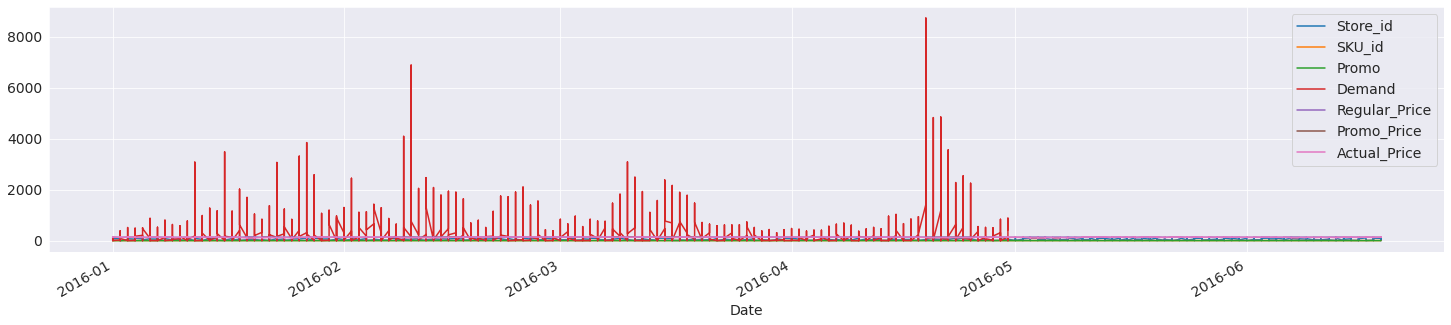

<Figure size 1800x360 with 0 Axes>

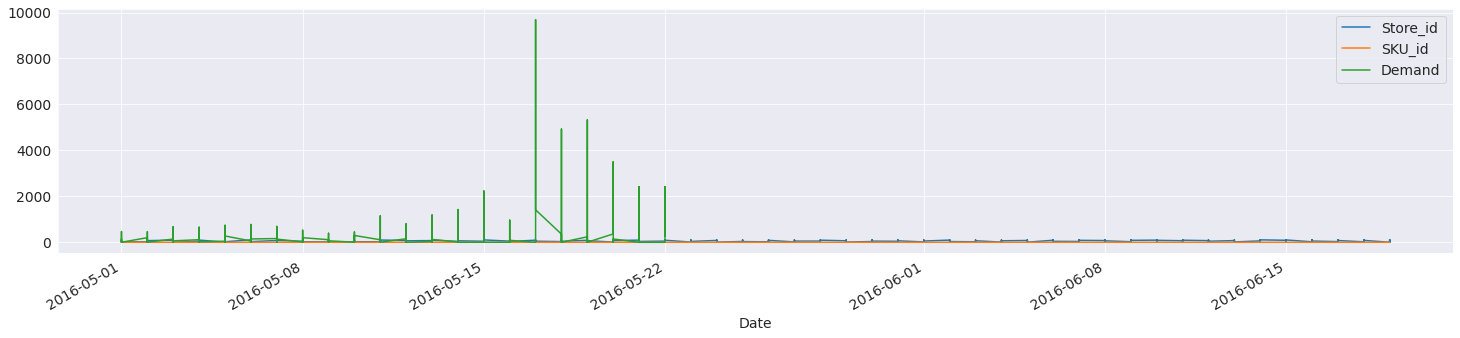

In [12]:
# prepare test/train datasets
test_start_dt = '05-01-2016'
train = ts_retail.copy(deep=True)
train.loc[test_start_dt:, 'Demand'] = np.NaN
train.loc['01-01-2016':].plot()
test_y = ts_retail.loc[test_start_dt:, ['Store_id', 'SKU_id', 'Demand']]

plt.figure()
test_y.plot()

In [13]:
test_y.shape

(10502, 3)

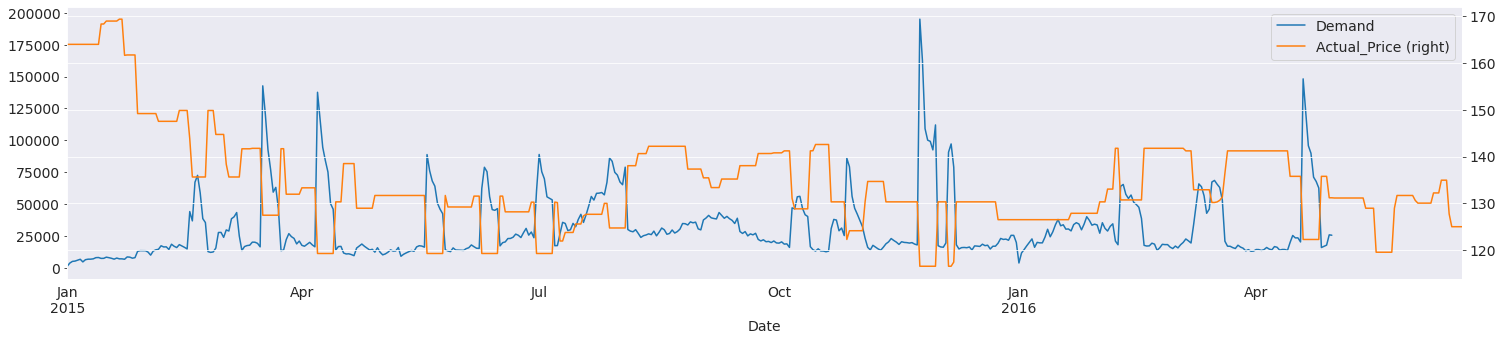

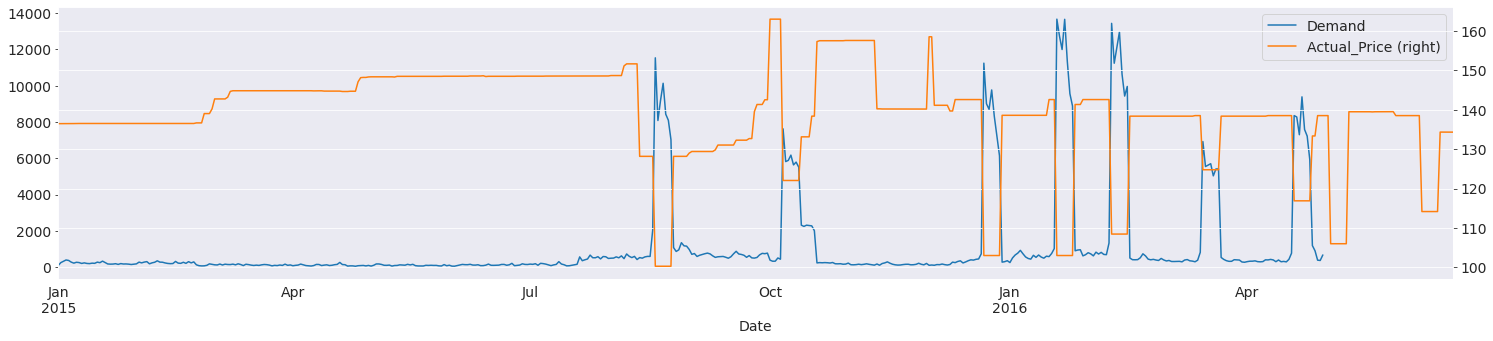

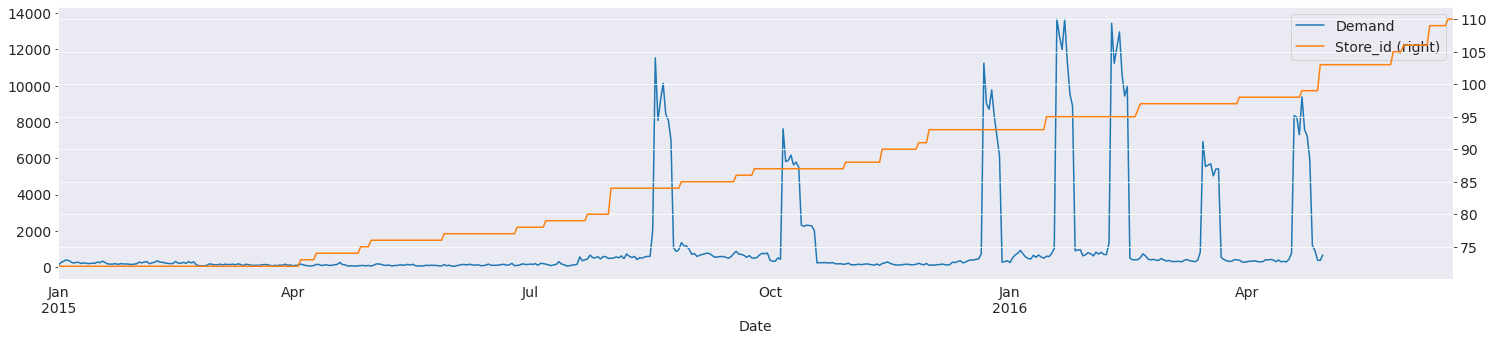

In [14]:
# Aggregate on Sku - All Stores level
sales_by_sku = train.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Actual_Price':'mean'}).reset_index().set_index('Date')
sales_by_sku.loc[test_start_dt:,'Demand'] = np.NaN # fill test period Demand with Nan

sales_by_sku[sales_by_sku['SKU_id'] == 1][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

sales_by_sku[sales_by_sku['SKU_id'] == 2][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

sales_by_sku[sales_by_sku['SKU_id'] == 2][['Demand', 'Store_id']].plot(secondary_y = ['Store_id'])

# ML for time series Forecasting

**Questions**
* Can classic ML algorithms (including DT regressor, Boosting, RF regressors)   be applied to the ts forecasting problem?
  - Yes, assuming that ts model is defined properly

* How CV should be organized for ts problem?

<img src = 'https://miro.medium.com/max/753/1*qvdnPF8ETV9mFdMT0Y_BBA.png' width = '2500px'>

## Feature generation for ML algorithms
**Questions**
* What features should be added to the original data set?
   - Calendar-dummy variables: holidays, day of week, day of month
   - Lagged-features
   - x-sindicated features (e.g price x store_number**2)

In [15]:
# feature generation
data = sales_by_sku.reset_index().copy(deep = True)

data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,Date,SKU_id,Demand,Promo,Store_id,Actual_Price,weekday,monthday,is_weekend
0,2015-01-01,1,1180.0,0.0,73,163.920685,3,1,0
1,2015-01-02,1,3667.0,0.0,73,163.920685,4,2,0
2,2015-01-03,1,4987.0,0.0,73,163.920685,5,3,1
3,2015-01-04,1,5226.0,0.0,73,163.920685,6,4,1
4,2015-01-05,1,5951.0,0.0,73,163.920685,0,5,0


### Lagged Features Generation

**Questions**
* Classic TS models leverage ts structure information (level, seasonaliry, trend, etc) for forecasting. How to provide such information for classsic ML models?

  - Answer: use ES forecast as features for ML  -->
     - Use more complicated ts based feature generation https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/LaggedFeaturesGeneration.PNG?raw=true'>

In [16]:
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# train[['SKU_id', 'Store_id', 'Demand']].groupby(['SKU_id', 'Store_id']).agg({'mean', 'std', percentile(50)})

# добавляем лаги
def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(df)

    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
      # print(bundle)
        # define dates for each SKU and Store pairs        
      condition = ' & '.join([keys[i]+ filters[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0
        
      if len(df[_idx].index)>0:
        for w in windows:
          lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                    groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
          for l in lags:
            new_names = {x: "lag{0}_wdw{1}_{2}_{3}".
                          format(l, w, x, name) for x in lf_df.columns }

            out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                  how='left', on =all_id_columns )
            
    return out_df

**Questions**
  * How to define lagges based on forecast horizon?
    - Lag must be less or equal than forecast horizon in order to prevent target leakage!
    - We are building forecast fot the next 22 days => minimal lag value is 22

In [17]:
flts = {'Promo': {'oprm':'>0', 'npromo':'==0', 'aprm':'>-1'}, 'weekday' : {'md':'==0', 'tue':'==1', 'wd':'==2', 'th':'==3', 'fr':'==4', 'sa':'==5', 'su':'==6', 'anyday':'>-1'}}
# data with added lagged features
data_lagged_features = lagged_features(data, target_var = 'Demand'
                    , org_id_columns = ['Store_id', 'SKU_id']
                    , all_id_columns =['Store_id', 'SKU_id', 'Date']
                    , lags = [22, 28]
                    , windows = [14, 28, 56]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = flts
                    )

In [ ]:
# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

585


Index(['Date', 'SKU_id', 'Demand', 'Promo', 'Store_id', 'Actual_Price',
       'weekday', 'monthday', 'is_weekend', 'lag22_wdw14_mean_oprm_md',
       ...
       'lag28_wdw28_median_aprm_anyday', 'lag28_wdw28_pctl90_aprm_anyday',
       'lag22_wdw56_mean_aprm_anyday', 'lag22_wdw56_pctl10_aprm_anyday',
       'lag22_wdw56_median_aprm_anyday', 'lag22_wdw56_pctl90_aprm_anyday',
       'lag28_wdw56_mean_aprm_anyday', 'lag28_wdw56_pctl10_aprm_anyday',
       'lag28_wdw56_median_aprm_anyday', 'lag28_wdw56_pctl90_aprm_anyday'],
      dtype='object', length=585)

## ML model definition
**Questions** 
* Shall we train anly one model for all data?
<img src = 'https://image.slidesharecdn.com/slides-logicyandex-2010-100616013322-phpapp02/95/-10-728.jpg?cb=1276652035'>
* Can we split all data based on business logics?

In [ ]:
data_lagged_features.set_index('Date', inplace = True)
data_lagged_features.loc[test_start_dt:].head()

,SKU_id,Demand,Promo,Store_id,Actual_Price,weekday,monthday,is_weekend,lag22_wdw14_mean_oprm_md,lag22_wdw14_pctl10_oprm_md,lag22_wdw14_median_oprm_md,lag22_wdw14_pctl90_oprm_md,lag28_wdw14_mean_oprm_md,lag28_wdw14_pctl10_oprm_md,lag28_wdw14_median_oprm_md,lag28_wdw14_pctl90_oprm_md,lag22_wdw28_mean_oprm_md,lag22_wdw28_pctl10_oprm_md,lag22_wdw28_median_oprm_md,lag22_wdw28_pctl90_oprm_md,lag28_wdw28_mean_oprm_md,lag28_wdw28_pctl10_oprm_md,lag28_wdw28_median_oprm_md,lag28_wdw28_pctl90_oprm_md,lag22_wdw56_mean_oprm_md,lag22_wdw56_pctl10_oprm_md,lag22_wdw56_median_oprm_md,lag22_wdw56_pctl90_oprm_md,lag28_wdw56_mean_oprm_md,lag28_wdw56_pctl10_oprm_md,lag28_wdw56_median_oprm_md,lag28_wdw56_pctl90_oprm_md,lag22_wdw14_mean_oprm_tue,lag22_wdw14_pctl10_oprm_tue,lag22_wdw14_median_oprm_tue,lag22_wdw14_pctl90_oprm_tue,lag28_wdw14_mean_oprm_tue,lag28_wdw14_pctl10_oprm_tue,lag28_wdw14_median_oprm_tue,lag28_wdw14_pctl90_oprm_tue,...,lag22_wdw28_mean_aprm_su,lag22_wdw28_pctl10_aprm_su,lag22_wdw28_median_aprm_su,lag22_wdw28_pctl90_aprm_su,lag28_wdw28_mean_aprm_su,lag28_wdw28_pctl10_aprm_su,lag28_wdw28_median_aprm_su,lag28_wdw28_pctl90_aprm_su,lag22_wdw56_mean_aprm_su,lag22_wdw56_pctl10_aprm_su,lag22_wdw56_median_aprm_su,lag22_wdw56_pctl90_aprm_su,lag28_wdw56_mean_aprm_su,lag28_wdw56_pctl10_aprm_su,lag28_wdw56_median_aprm_su,lag28_wdw56_pctl90_aprm_su,lag22_wdw14_mean_aprm_anyday,lag22_wdw14_pctl10_aprm_anyday,lag22_wdw14_median_aprm_anyday,lag22_wdw14_pctl90_aprm_anyday,lag28_wdw14_mean_aprm_anyday,lag28_wdw14_pctl10_aprm_anyday,lag28_wdw14_median_aprm_anyday,lag28_wdw14_pctl90_aprm_anyday,lag22_wdw28_mean_aprm_anyday,lag22_wdw28_pctl10_aprm_anyday,lag22_wdw28_median_aprm_anyday,lag22_wdw28_pctl90_aprm_anyday,lag28_wdw28_mean_aprm_anyday,lag28_wdw28_pctl10_aprm_anyday,lag28_wdw28_median_aprm_anyday,lag28_wdw28_pctl90_aprm_anyday,lag22_wdw56_mean_aprm_anyday,lag22_wdw56_pctl10_aprm_anyday,lag22_wdw56_median_aprm_anyday,lag22_wdw56_pctl90_aprm_anyday,lag28_wdw56_mean_aprm_anyday,lag28_wdw56_pctl10_aprm_anyday,lag28_wdw56_median_aprm_anyday,lag28_wdw56_pctl90_aprm_anyday
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01,1,NaN,0.0,103,131.16,6,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92439.0,92439.0,92439.0,92439.0,23535.75,14818.8,19707.5,35315.3,92439.0,92439.0,92439.0,92439.0,23535.75,14818.8,19707.5,35315.3,14495.083333,13149.8,14248.0,16061.4,13737.000000,13021.0,13917.5,14272.5,14495.083333,13149.8,14248.0,16061.4,13737.000000,13021.0,13917.5,14272.5,14495.083333,13149.8,14248.0,16061.4,13737.000000,13021.0,13917.5,14272.5
2016-05-02,1,NaN,0.0,103,131.16,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14442.769231,13198.6,14246.0,16044.8,13808.714286,13037.0,14239.0,14268.0,14442.769231,13198.6,14246.0,16044.8,13808.714286,13037.0,14239.0,14268.0,14442.769231,13198.6,14246.0,16044.8,13808.714286,13037.0,14239.0,14268.0
2016-05-03,1,NaN,0.0,103,131.16,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14435.571429,13247.4,14248.0,16028.2,14071.625000,13053.0,14242.5,14780.1,14435.571429,13247.4,14248.0,16028.2,14071.625000,13053.0,14242.5,14780.1,14435.571429,13247.4,14248.0,16028.2,14071.625000,13053.0,14242.5,14780.1
2016-05-04,1,NaN,0.0,103,131.16,2,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14438.857143,13247.4,14270.5,16028.2,14133.888889,13069.0,14246.0,14888.0,14426.266667,13296.2,14250.0,16011.6,14133.888889,13069.0,14246.0,14888.0,14426.26666

In [ ]:
# train specific model for each SKU
sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

## ML Model Training

In [ ]:
# try lightgbm as ml algorithm
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

In [ ]:
# without CV
lgbm1 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm1.fit(X = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1), y = sku1_train.loc[:test_start_dt].Demand)

lgbm2 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

lgbm2.fit(X = sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1), y = sku2_train.loc[:test_start_dt].Demand)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7, importance_type='split', learning_rate=0.1,
              max_depth=-1, metric='mae', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
              n_jobs=-1, num_leaves=40, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.4,
              subsample_for_bin=200000, subsample_freq=0)

### Cross-validation for time series

In [ ]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

## Forecast Generation with ML

In [ ]:
# Train sets
X_train1 = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand'], axis=1)
y_train1 = sku1_train.loc[:test_start_dt].Demand
X_train2 = sku2_train.loc[:test_start_dt].drop(['SKU_id', 'Demand'], axis=1)
y_train2 = sku2_train.loc[:test_start_dt].Demand

In [ ]:
# test sets
X_test1 = sku1_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)
X_test2 = sku2_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)

In [ ]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [ ]:
# train for the sku 1
%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm, wape, kwargs)

Size train set: (487, 582)
Size of each fold: 28

Splitting the first 2 chunks at 1/2
Size of train + test: (56, 582)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 10998.9
[4]	valid_0's l1: 10998.9
[6]	valid_0's l1: 10998.9
[8]	valid_0's l1: 10998.9
[10]	valid_0's l1: 10998.9
Early stopping, best iteration is:
[1]	valid_0's l1: 10998.9

Splitting the first 3 chunks at 2/3
Size of train + test: (84, 582)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 23269.7
[4]	valid_0's l1: 22533.2
[6]	valid_0's l1: 22132.9
[8]	valid_0's l1: 21893.4
[10]	valid_0's l1: 21676.6
[12]	valid_0's l1: 21471.6
[14]	valid_0's l1: 21288.2
[16]	valid_0's l1: 20887.8
[18]	valid_0's l1: 20515.9
[20]	valid_0's l1: 20161.8
[22]	valid_0's l1: 20015.9
[24]	valid_0's l1: 19685.9
[26]	valid_0's l1: 19423.3
[28]	valid_0's l1: 19399.2
[30]	valid_0's l1: 19149.4
[32]	valid_0's l1: 19129.2
[34]	valid_0's l1: 18957.4
[36]	valid_0's l1: 18737.9
[38]	valid_0's 

32.984837752580276

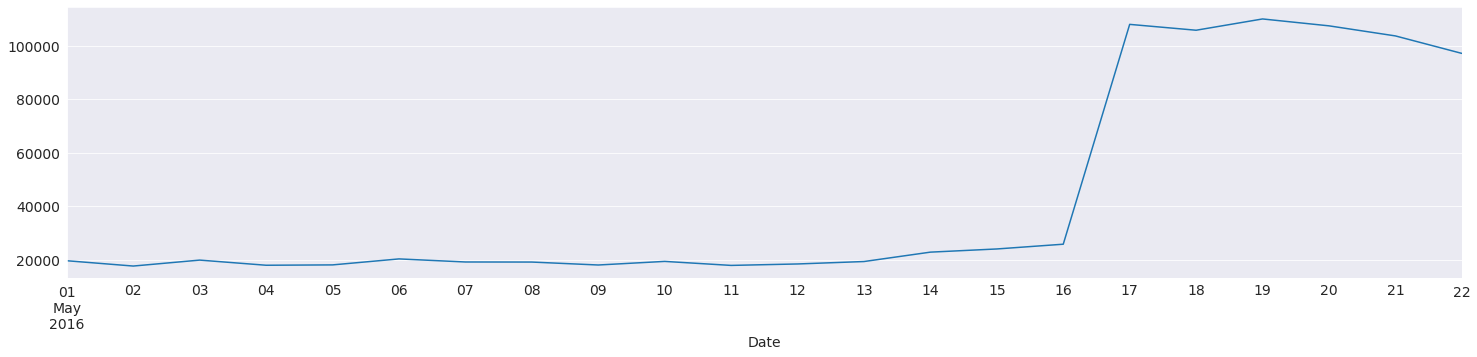

In [ ]:
# forecast for sku 1
X_test1['y_pred'] = lgbm.predict(X_test1)
X_test1['y_pred'].plot()

In [ ]:
# train for product 2
performTimeSeriesCV(X_train2, y_train2, 17, lgbm, wape, kwargs)

Size train set: (487, 582)
Size of each fold: 28

Splitting the first 2 chunks at 1/2
Size of train + test: (56, 582)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 222.772
[4]	valid_0's l1: 222.772
[6]	valid_0's l1: 222.772
[8]	valid_0's l1: 222.772
[10]	valid_0's l1: 222.772
Early stopping, best iteration is:
[1]	valid_0's l1: 222.772

Splitting the first 3 chunks at 2/3
Size of train + test: (84, 582)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 90.9992
[4]	valid_0's l1: 88.409
[6]	valid_0's l1: 84.7253
[8]	valid_0's l1: 81.435
[10]	valid_0's l1: 80.5108
[12]	valid_0's l1: 78.1778
[14]	valid_0's l1: 75.5734
[16]	valid_0's l1: 72.7192
[18]	valid_0's l1: 70.0459
[20]	valid_0's l1: 67.5046
[22]	valid_0's l1: 66.545
[24]	valid_0's l1: 65.2155
[26]	valid_0's l1: 62.9654
[28]	valid_0's l1: 62.0951
[30]	valid_0's l1: 60.0287
[32]	valid_0's l1: 58.0705
[34]	valid_0's l1: 57.053
[36]	valid_0's l1: 56.3076
[38]	valid_0's l1: 

39.58364371565857

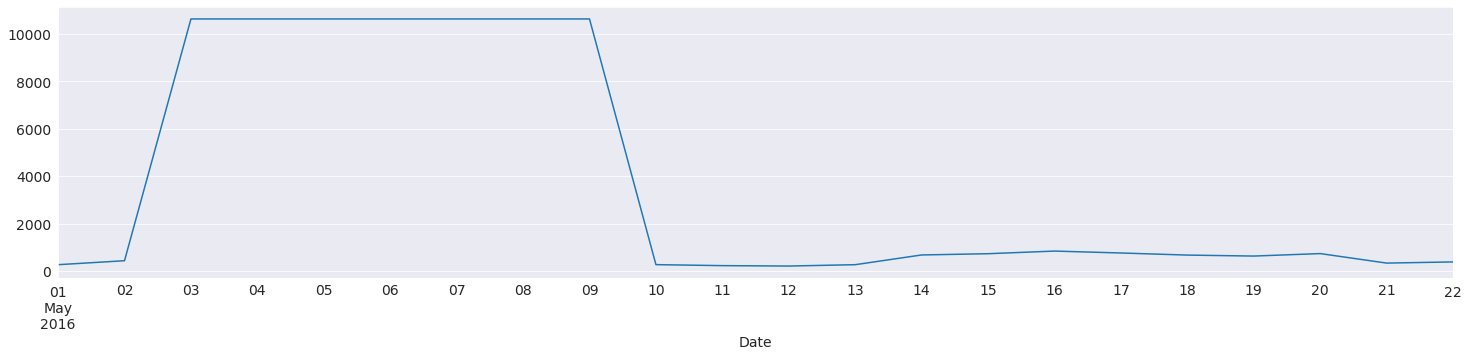

In [ ]:
# предсказываем продукт2
X_test2['y_pred'] = lgbm.predict(X_test2)
X_test2['y_pred'].plot()

In [ ]:
y_true[y_true['SKU_id']==1].head()

,SKU_id,Demand
Date,,
2016-05-01,1,10640
2016-05-02,1,10719
2016-05-03,1,13098
2016-05-04,1,16267
2016-05-05,1,18283


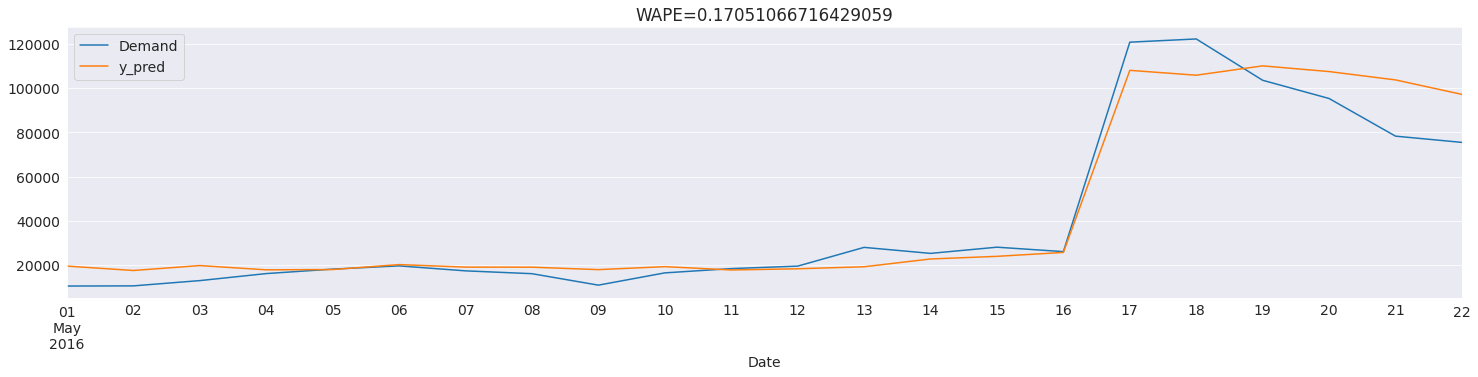

In [ ]:
y_true = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index().set_index('Date')

# WAPE for sku 1
qlt , _ = qualityWAPE(y_true[y_true['SKU_id']==1]['Demand'], X_test1['y_pred'])

#draw forecast and actuals
X_test1.merge(y_true[y_true['SKU_id']==1], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'WAPE='+str(qlt))


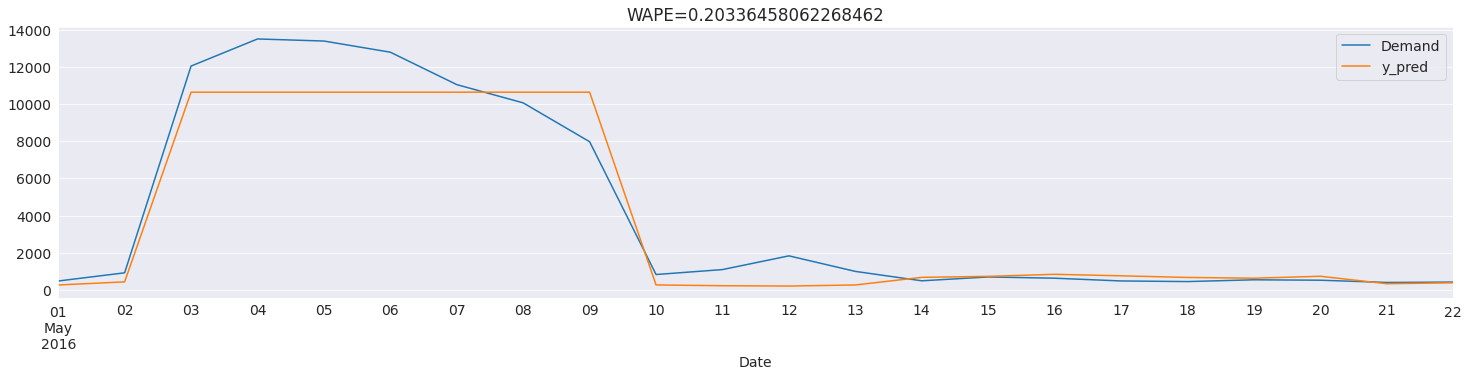

In [ ]:
# WAPE for sku 2
qlt , _ = qualityWAPE(y_true[y_true['SKU_id']==2]['Demand'], X_test2['y_pred'])

#draw forecast and actuals
X_test2.merge(y_true[y_true['SKU_id']==2], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'WAPE='+str(qlt))


# HW3
* contest in kaggle: max 2 submits per day (to prevent overfitting)
* you may use any 
* 2 benchmarks:
  - you'll get $mark \in (6, 8]$ of 10 if your approach outperforms benchmark1
  - you'll get $mark\in (8,10]$ of 10 if your approach outperforms benchmark2
  - final $mark$ will be derived based on leaderboard
  - you have to send code with the final solution to the google form https://forms.gle/Jafoe52VmyraPbgP7 (otherwise final mark will be 0)


**Materials**
* Cross-validation for time series https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
* M - competition
  - M5: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163414
  - M4: https://www.sciencedirect.com/science/article/pii/S0169207019301128